# Init

In [16]:
%matplotlib inline

import os
import arrow
import datetime
import pickle
import pandas as pd
from IPython.display import clear_output

import cfg4py
import omicron
import numpy as np
from omicron.core.types import FrameType
from omicron.models.securities import Securities
from omicron.models.security import Security

from alpha.core.features import predict_by_moving_average, moving_average,fillna
from alpha.plotting import draw_trendline
from alpha.config import get_config_dir
from alpha.strategies.twins import Twins
from alpha.core.morph import MorphFeatures

cfg4py.init(get_config_dir())
await omicron.init()


try:
    model = "/root/alpha/data/twins/twins-30m-v1.pkl"
    twins  = Twins.load(model)
except Exception:
    twins = Twins("30m")
    
clear_output()

# 加载数据

In [2]:
with open("/data/datasets/ds_even_30m_300_5000.pkl", "rb") as f:
    ds = pickle.load(f)

In [7]:
df = pd.DataFrame(ds["data"], columns=["code", "y", "bars"])

In [8]:
def ylabel(bars):
    yclose = bars["close"][-10:]
    c0 = bars["close"][-11]
    
    max_adv = max(yclose) / c0 - 1
    max_dec = abs(min(yclose) / c0 - 1)
    
    agg = max if max_adv > max_dec else min
    
    return agg(yclose) / c0 - 1
    
df.y = df.bars.apply(lambda x: ylabel(x))
def add_xend(bars):
    return bars["frame"][-11]
df["xend"] = df.bars.apply(add_xend)

/conda/envs/alpha/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/conda/envs/alpha/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
2021-09-06 21:45:58,345 W 9179 matplotlib.text:draw:688 | posx and posy should be finite values
2021-09-06 21:45:58,424 W 9179 matplotlib.text:draw:688 | posx and posy should be finite values
2021-09-06 21:45:58,520 W 9179 matplotlib.text:draw:688 | posx and posy should be finite values


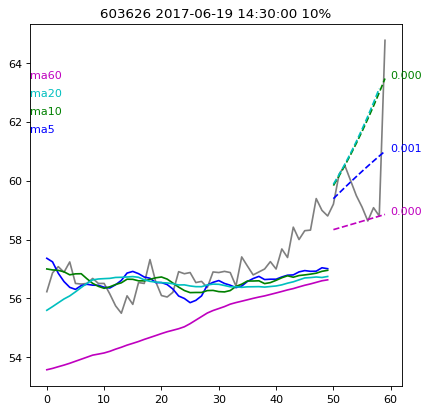

In [11]:
def draw(i):
    code, y, bars = df.loc[i]
    xend = bars["frame"][-11]
    desc = f"{code.split('.')[0]} {str(xend).replace('+08:00', '')} {y:.0%}"
    draw_trendline(bars["close"], 10, save_to = f"/data/twins/{code}.jpg", desc=desc)
    
for i in df[df.y>0.1].index:
    draw(i)
    break

In [ ]:
code, y, bars = df.loc[625]
close = bars["close"]
print(code, close[-6:])
predict_by_moving_average(close[:-5], 10, 5)

# build morph库

In [ ]:
m = MorphFeatures(FrameType.DAY)

def add_pattern(bars):
    for i in range(220):
        close = bars["close"][i:i+81]
        if np.count_nonzero(np.isfinite(close)) < 81*0.9:
            continue
            
        close = fillna(close.copy())
        m.encode(close)

df.bars.apply(add_pattern)
m.dump()

# 增加样本

In [ ]:
twins.add_pattern()